# AR comparison of modelling theairco sound

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using LAR
using LAR.Node
using FFTW
using Distributions

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
include("../functions/auxiliary/warpedfilter.jl")
include("inference.jl")
;

## Adjustable parameters

In [2]:
# signal preprocessing
sound_file = "../data/woman.wav"      # specify sound location
fs_desired = 8000                        # specify desired sampling frequency

# inference and modelling
AR_order_max = 30                            # order of auto-regressive model
iterations = 5                           # number of iterations for variational message passing
Λ_meas = 1e4                            # assumed precision of measurement noise
;

## Load data

In [3]:
# load and process speech signal
x_time, fs_time = wavread(sound_file, format="native")
fs_time = Int(fs_time) 
x_time = x_time[0*fs_time+1:3*fs_time]
x_time = resample(x_time, fs_desired/fs_time)
x_time = 20*x_time/var(x_time)

x_freq = Float64[]
for k = 1:length(x_time)-32
    push!(x_freq, real(FFTW.fft(x_time[k:k+31])[8]))
end

# specify time axis
t = collect((1:length(x_freq))/fs_desired)

# create audioplayer
audioplayers(x_time, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQABOvm6MnHkO1P7dTvhDsy5ZXOGulgF/TvvrFG6o/wRO/c3CTpSkm472WJauwtozTlTEju7+cPnuoKZdjq0P/A6YyK8Oo4x87tIPLo7hmbaO4AONboKDgu7cZKVO8IFJzzwgcs5dtFAu3FPWztXyXA7bmKQudJFVrzTeLk6vvkOO/1QUTu0Jb+70PUPu3D3PDxIEUe7fe5nuNgPALvIJMw7t096O6wAeLvkVoe5auC0OlQ7eTqRj886/Gadug5LoboEk4Y7Hj2POrlpJTvKVyC7aQk/OfVYGThBvUE763o8O/DnTrrEmgU7Ic54uTKSELpN1y47hGxcOxREqLr7ouU6oUdZObm/A7vJRY+7sIzuO9uxBTplVw06B7gDvNazBzxOWDs71nfiOAf9Lrv6sok7eySlOzZtkbuiQnI7mRinOwqtxLkhfb27ovkoO9De5TuN20E7pjrOuuj/qzu3xdw7WvqcOngrk7q+NUo79CWpOhiDorp3Pya6YtQjOzhYOzupfNA6PpAjuhwyBzw6k6E7oO0lOrhBJzteFqU7E+g9OyBA4LqVM646XHL3OrsnG7vf+d25leWhulin1jqwGoY7oWiSuqmYKDvSh507S1+yOz4Vy7trjDa6juwdO7yri7o+jpE6Wjgfu83e3rpFe9w64FGfOg0ShztYkJG6S8pkO8m+6Tkprrq5KX5mO57JEDvtod07PSdPu9H+H7r8Cqq6E/ikO3Nqk7r0T5C7/wXvuoG8zbo+QaQ7pGI4ug7D47v/TIC5aWGWOwQFPzvZA6q65Mmgu3+qFDwsZYY7OoxCu2E/+LuaKgs75rTwOvToU7i2MWy7TT8SO0qGgzty0Gk5dGlOu+YevLqL9tM6T3oQu5I1RLtkbyu7L0iOOfMljrtclnW7BeiLu1QonbqvNG+75BfqOvOTnrtsLxq52lEVulNBiLtqWwK7ZP7huRAoxDoXSdi75OLVunCoz7oUuw0758sgu5i3/bpUgUU778UZOdmLeroe+Ie7zDmyug6TI7r8eL46O1EVuhwIgzswCGu7P2R2u09V0LoPh2Q7XjbnugN1ArxIqE07cHu/O1+5fbugLAW8IkNQu4dkwDuWJ4878CYgvLZpPrvd5eg7pWL1OzoAWLxZxYG7gB4FO3TyETyOkqK6QTOpu4ZMoLuazr07MdEOO/NdXbuP6Ly748kCOQgbmDumM9S6P5rmuzncAzpu/zk7WqSAuzI5irvPk4m7gKpDO3sT6jqffrG6XP9Wuwcia7pnbHM7FoKhOrx3rruKI926zwYdu4W+bzrD/tC7RIwUumRYObs/6si55tizO/smjLopube6MlB0usuTwzpan6k5LXffN13UNru4onW6EET4unGPOruKbMW7+vopO4ytdrv+i+G6Txu3ukLcZTuPafm56whpu0h7brtu4UG7G5BBOw5nXrqMUa274/fKu2Y73TjlYZ67wp3su/bwiLuVdlM7bn5HuyNZvjmJRT06gj0YO2u/Cbye8wa6ORCrO0VI2roh5R28heavu7b/DjtqbYe7u60cvGF+hrsGC9C67J5NO576i7vfRHO6vKNIu+AKkrm5d6k6uxvPu8PSJzq7zGS33AcVOxAKJLyiRkc7sW7gO0AdzbsnQJ+7TcIaO/KQEjxTIrG76C2cu0sfdroOeR86Df7Vu48yJDrz30a7TzalO/ePnbstNC+5+zCHOT8kiTrhxrA7r20SvHHFhbu0F/g6gob0O8Vlr7sTIH+7942QO4C8Mjwn46o6Cm+0u00hErpi8tU7OejIutn5p7o34bQ6Rux6O/pdBDud9Ny7fUeOO+SI5jsXFw27Oly3uwYxjbvKawg8RoVuu7cbKrs8U1m7UPk8O6VVvrlpYBY7zFhzOjBAbju9utW6618tub76ADpgHG67mw5zO19whTuyt+U6Vnj2u0ZMxDofK907I8laOpGxIrxQRRI7wIL7O8cYzzm0fgq8NI7vupXiAzz9wvA70ZsDuYtOfbv58N076EAFPAzyHbtdjKW6FxokukVWdjrsxNQ6Nn6Iuwy73DoyP147d0gbu/WfTjsq+o26CvrgO9vWPDq00OO6AnGJNxYCtTp74Kg7UpA3u5PEFDswwaA7w03BOv1FVrsMKkY64xzGO/G9EbucyKC7D5UeOwHjEzrzgqK7BFjsuq7s4juMNQ87tyCBuhgIBTvlGjw7ye3VO0LIXDvLcOU6leg6uiIZRrswvQa6IhHEuHjdjLrdGVa7rKKbuox5CjvhFyg66i0Qux42xzos44U6phwZO8Xy/jr5qQU7pLQ8O/xnwDqU/So7uueLOndFJTzS7QK7wuHduoAljrpO5WI6ceVQu8cqB7vhTQ87ED1nO2I4azqb9ry618kFuvD+Qjse0YA792ewusPxebvlw4S75OHfO2nAB7tv9Ni7y7C3u6lOILl2eGA7zVPEuu/WYrrfGqu7hTFmOx3p8zma0wK8fNNyu4f5ALuMQDM7gJ96O4Udj7qRKim7mdGwOoVHajtB318726f0uvZWZbtcNz47y1yhO9YVrbvRcfu7trJeOhhAzDkWQoQ6BRZZO44U7jnP4fo7z+sDOrpNYzqNC107O7c1O9chCDtoz3+7ky25OkbDwzox5+g5zUMNvLsepztZQcM7loCMuxunBLzO7Ic7mvbkO5+cO7tmTgK81EubOz3zfzsYE5k7I8wcu/iyYzmwBZk30QgNO8yaPLtEobu7mWkkuz8/hTqFhYy7CQr8u6tkzLrlLzE69tMqO7pXwLuHhNS6i+puO28WkDvrA/+7FufCur9LgLpn2CE7a63Euz5BxbvhUym6yZG8uoFmTLsylhG78c4QO6mdPbswMpY6TGsnO1SxWzoabuC6Lt3Pt+P397rk8L460BgdOuuaebp8XX27MjRFuojWeTtcWjq7xFPhOaRYazlRxgk6Wv0/u6Zh/DoxWpO7YxSFu5m3NTvV+y47wt0EO4+hLLyDE5I7xvLaOmRdq7l+iR27u/c4u8mP0DozjY87me/cOrnJrDqw7wa7MXZlOhE89Tv/FZ47ibJ/OSpvKrvgJgm7gX/fOz/BrDqqR1q7kXdqu5BUajvCYLM7YVtlu9b9jbskgvA6gluFO8qc0DlWmhm7XqQsum9Z5jqghB27n9GDu5MTU7t9wb47LU+sOsrXl7qQ3ra6ePKUO5InbTsavRW7/14ku1/CH7u58I475MIzu7QaG7tkwnW6KkSWukXgabsqagK70LdVOuNqT7r3Ehi7LemqOe8NXbrmXGy669Q8uzAyKjuzTOI4MMMMu8Abm7oVBlw6lho6Oq6uL7se64O6SMN4ueNNELsu8Pk6aXBXu5Zs/7hWxsW5wSnUurW1FbvqyKe56GNSO1UjRLvHktK7aOw/O2xeqjo1N923YLWYu/Tf0LpeWTE6csdPu6Um0bsRIVi71JUEOrSKzbpSrca6K32iu78gALomYY47kXIau5vBubtjQMW6xtGHO0mtDTqF1pS7/gd5u2zsQzo7G6O60v8IuwqY4rrUizG7z+JAO4FNN7ooZI47dW0yu7QKgzqRfPs4KgxyuyYZ7LsC0yM7l+ncOz+wE7ox79o6sjegu7t4GTv/75K6kxsBu0huYrtXtnM7bDF+O3DROjpFa/u6lH/0unHoabgq9I27BGyfu8//H7mZyV27hYSgu/CplroUGo64bh01u39Rx7tYjZS5wx8SuxcdBTqUvUW7Dsv4N5ROnzrUaBE6kFp2ul6Q77rfO3E7MsTQulO+wLvy5X276dw7OwddNruRL/q65KlKugbKnTvwbfq3J0C7OoCfULos3F668OI1O7FDEjqbS7I6j7W8u8k+izswdiO5O1VzOgK4mrvHhnU6ZA0pO3qXEztcO

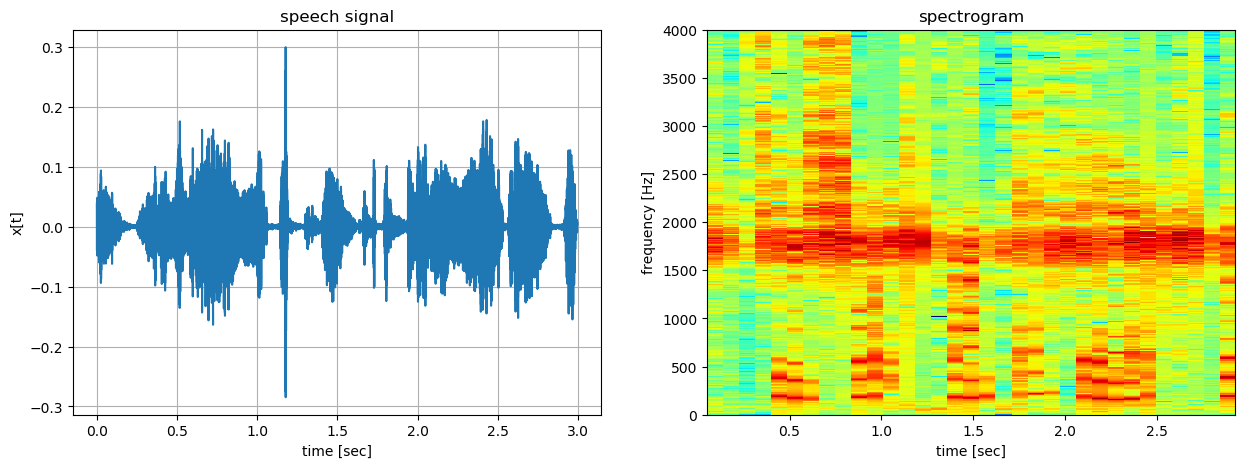

In [4]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_freq)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_freq, convert(Int, 100e-3*fs_desired), convert(Int, 10e-3*fs_desired), fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("speech signal"), ax[2].set_title("spectrogram")
;

## Generative model and inference

In [5]:
mem_AR = Float64[]
mem_MSE = Float64[]
mem_MAE = Float64[]
mem_BME = Float64[]

for AR = 1:AR_order_max
    
    # create FactorGraph
    q = create_fg(AR, Λ_meas)
    
    # perform inference
    μ_pred, Λ_pred = perform_inference(x_freq, AR, q, iterations)
    
    # get performance scores
    MSE, MAE, BME = score_predictions(x_freq, μ_pred, Λ_pred)
    
    # print results
    println("AR order: "*string(AR))
    println("----MSE: "*string(MSE))
    println("----MAE: "*string(MAE))
    println("----BME: "*string(BME))
    
    # save results
    push!(mem_AR, AR)
    push!(mem_MSE, MSE)
    push!(mem_MAE, MAE)
    push!(mem_BME, BME)
end



AR order: 1
----MSE: 0.0011486346073384926
----MAE: 0.02231751384713258
----BME: 1.9023836259100673
AR order: 2
----MSE: 0.0005705030963510351
----MAE: 0.01550353779663543
----BME: 2.2206703831942325
AR order: 3
----MSE: 0.0004230156313970444
----MAE: 0.01332230803813261
----BME: 2.3255563124288967
AR order: 4
----MSE: 0.00038317696745917
----MAE: 0.012446384486573266
----BME: 2.3807812921822133
AR order: 5
----MSE: 0.00039207043971370377
----MAE: 0.012535558286660775
----BME: 2.3815588191432515
AR order: 6
----MSE: 0.00036929804292753766
----MAE: 0.01222988812750596
----BME: 2.4005368951045956
AR order: 7
----MSE: 0.000339761381340537
----MAE: 0.011775625558647158
----BME: 2.4420116442860165
AR order: 8
----MSE: 0.0003425907267820996
----MAE: 0.011776083208005153
----BME: 2.4418050165691803
AR order: 9
----MSE: 0.0003450913725654364
----MAE: 0.011744505743948247
----BME: 2.441739882320444
AR order: 10
----MSE: 0.0003438581176397504
----MAE: 0.01172137298443234
----BME: 2.4427178674301

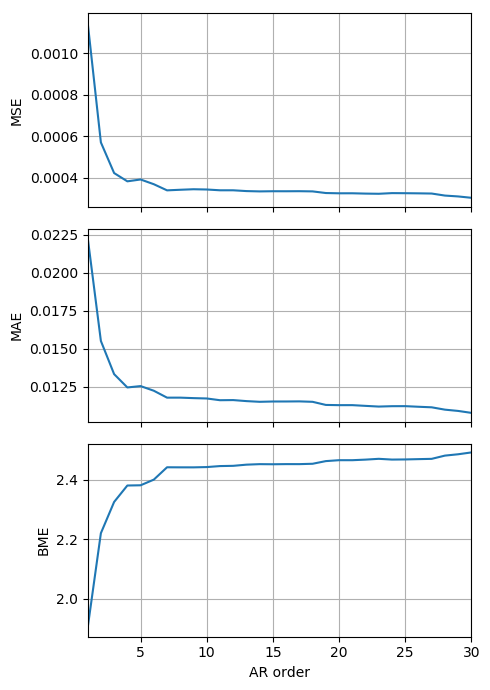

In [15]:
_, ax = plt.subplots(nrows=3, figsize=(5,7), sharex=true)

ax[1].plot(1:AR_order_max, mem_MSE)
ax[2].plot(1:AR_order_max, mem_MAE)
ax[3].plot(1:AR_order_max, mem_BME)
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[1].set_ylabel("MSE"), ax[2].set_ylabel("MAE"), ax[3].set_ylabel("BME"), ax[3].set_xlabel("AR order"), ax[1].set_xlim(1,AR_order_max), ax[2].set_xlim(1,AR_order_max), ax[3].set_xlim(1,AR_order_max)
plt.tight_layout()
plt.savefig("figures/AR_comparison.png", dpi=500)
;